In [1]:
import scrapy
import json
import re
from scrapy.crawler import CrawlerProcess
from scrapper import gameScrapSpider, run_spider

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
import time

import matplotlib.pyplot as plt
import numpy as np

In [32]:
driver = webdriver.Chrome("env/Lib/site-packages/chromedriver.exe")
driver.get("https://www.promobit.com.br/promocoes/jogos-de-pc/s/")

action = ActionChains(driver)
action.move_to_element(driver.find_element_by_css_selector(".css-1xhzu1x"))
action.perform()

load_more_button = driver.find_element_by_css_selector(".css-1xhzu1x")
load_more_button.click()
time.sleep(3)
driver.execute_script("window.scrollTo(0, 5000)")
time.sleep(3)
action.move_to_element(driver.find_element_by_xpath("//span[contains(text(),'1 mes')]"))
action.perform()

selenium_response_text = driver.page_source
response = scrapy.Selector(text=selenium_response_text)

C:\Users\guilh\AppData\Local\Temp/ipykernel_4364/3885879011.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("env/Lib/site-packages/chromedriver.exe")
C:\Users\guilh\AppData\Local\Temp/ipykernel_4364/3885879011.py:5: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  action.move_to_element(driver.find_element_by_css_selector(".css-1xhzu1x"))
C:\Users\guilh\AppData\Local\Temp/ipykernel_4364/3885879011.py:8: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  load_more_button = driver.find_element_by_css_selector(".css-1xhzu1x")
C:\Users\guilh\AppData\Local\Temp/ipykernel_4364/3885879011.py:13: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  action.move_to_element(driver.find_element_by_xpath("//span[contains(text(),'1 mes')]"))


In [43]:
games_lista = []
SET_SELECTOR = '.css-wauoyl'
for game in response.css(SET_SELECTOR):
    NAME_SELECTOR = '.css-10227v0 ::text'
    OLDPRICE_SELECTOR = '.css-124gmjl ::text'
    NEWPRICE_SELECTOR = '.css-1u0404w ::text'
    STORE_SELECTOR = '.css-1a7v2lf ::text'
    games_lista.append({
        'name': game.css(NAME_SELECTOR).extract(),
        'store': game.css(STORE_SELECTOR).extract(),
        'price': game.css(OLDPRICE_SELECTOR).extract(),
        'discounted price': game.css(NEWPRICE_SELECTOR).extract(),
        'time': game.css('.css-1oxwbh0 ::text').extract(),
    })
    
print(len(games_lista))

# run_spider()

# with open("items.json") as file:
#     games_lista = json.load(file)

276


In [44]:
def cleanupTitle(full_title):
    if "Jogo" not in full_title:
        return full_title
    splitlist = re.split("Jogo | -", full_title)
    return splitlist[1]

def cleanupFullPrice(price_string):
    if price_string == "de graça!":
        return "0"
    else:
        splitlist = price_string.split("\xa0")
        price = splitlist[-1].replace(".","")
        return price.replace(",",".")

def cleanupFreeGame(price_string):
    if price_string == "de graça!":
        return "0"
    else:
        price = price_string.replace(".","")
        return price.replace(",",".")

In [62]:
games_by_store = {}
for item in games_lista:
    
    time = item['time'][0]
    if 'mes' in time or 'meses' in time or 'ano' in time or 'anos' in time:
        continue
        
    if item['discounted price'] == []:
        continue
        
    prices = {}
    full_title = item['name'][0]
    store = item['store'][0]
    discounted_price = item['discounted price'][0]
    
    game = cleanupTitle(full_title)
    discounted_price = cleanupFreeGame(discounted_price)
    
    if item['price'] != []:
        notclean_price = item['price'][0]
        full_price = cleanupFullPrice(notclean_price)
    else:
        full_price = cleanupFreeGame(item['discounted price'][0])
    
    prices = [full_price, discounted_price]
    
    if store not in games_by_store.keys():
        games_by_store[store] = []
    games_by_store[store].append({'game': game, 'prices': prices, 'time':time})

As melhores ofertas do mês:
Loja ubi.com com o jogo Tom Clancys Splinter Cell Chaos Theory gratis com 100.0% de desconto,
mudando de R$29.90 para R$0

A Loja Steam está com uma promoção incrível! Comprando 100 Games Bundle,
voce economiza R$883.76! De R$1210.19 para R$326.43

Aqui são alguns jogos de graça para você aproveitar!
Jogo TheHunter: Call of the Wild na loja epicgames.com
Jogo Multiplayer Halo Infinite - PC Steam na loja Steam
Jogo Die Young: Prologue na loja indiegala.com
Jogo Glorkian Warrior: The Trials Of Glork na loja indiegala.com
Jogo Rogue Heroes: Ruins of Tasos na loja amazon.com
Jogo Control Ultimate Edition na loja amazon.com
Jogo Dragon Age 3: Inquisition na loja amazon.com


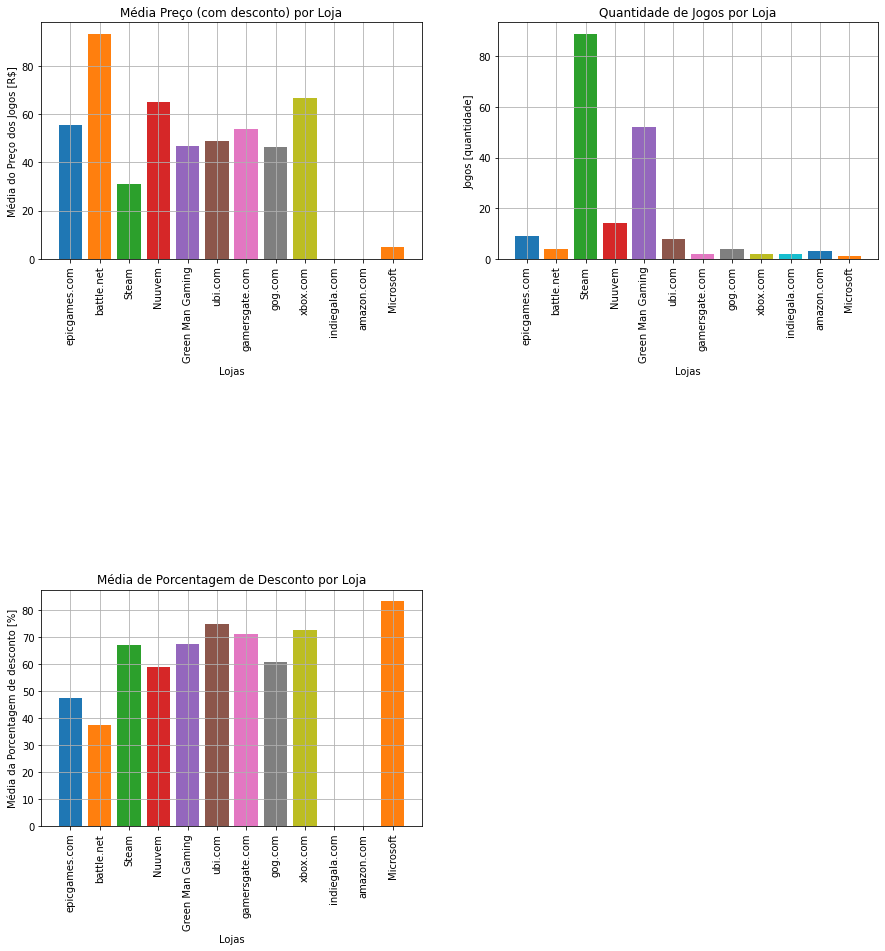

In [113]:
plt.figure(figsize=[15, 20])

best_deal_per = [[],[],[]]
dif = 0

best_deal_dinh = [{},""]
discount = 0

free_games = []

for store in games_by_store:
    num_games = len(games_by_store[store])
    all_prices = 0.0
    all_percentages = 0
    for games in games_by_store[store]:
        all_prices += float(games['prices'][1])
        
        price_full = float(games['prices'][0])
        discounted_price = float(games['prices'][1])
        if price_full == 0:
            percentage_discount = 0
        else:
            percentage_discount = 100-((discounted_price*100)/price_full)
    
        diferenca = price_full - discounted_price
        if diferenca > dif:
            dif = diferenca
            best_deal_dinh[0] = games
            best_deal_dinh[1] = store
            
        if price_full == 0:
            free_games.append([games, store])
            
        if percentage_discount >= discount:
            if percentage_discount == discount:
                best_deal_per[0].append(games)
                best_deal_per[1].append(store)
                best_deal_per[2].append(discount)
            else:
                discount = percentage_discount
                best_deal_per=([games], [store], [discount])

        
        all_percentages += percentage_discount
    
    mean_percentage = all_percentages/num_games
    mean_prices = all_prices/num_games        
    
    plt.subplot(4,2, 1)
    plt.title("Média Preço (com desconto) por Loja")
    plt.xlabel("Lojas")
    plt.ylabel("Média do Preço dos Jogos [R$]")
    plt.bar(store, mean_prices)
    plt.xticks(rotation = 'vertical')
    plt.grid(True)
    
    plt.subplot(4,2, 2)
    plt.title("Quantidade de Jogos por Loja")
    plt.xlabel("Lojas")
    plt.ylabel("Jogos [quantidade]")
    plt.bar(store, num_games)
    plt.xticks(rotation = 'vertical')
    plt.grid(True)
    
    plt.subplot(4,2, 5)
    plt.title("Média de Porcentagem de Desconto por Loja")
    plt.xlabel("Lojas")
    plt.ylabel("Média da Porcentagem de desconto [%]")
    plt.bar(store, mean_percentage)
    plt.xticks(rotation = 'vertical')
    plt.grid(True)

print(f'As melhores ofertas do mês:')
for i in range(len(best_deal_per[0])):
    print(f'Loja {best_deal_per[1][i]} com o jogo {best_deal_per[0][i]["game"]} com {best_deal_per[2][i]}% de desconto,\n\
mudando de R${best_deal_per[0][i]["prices"][0]} para R${best_deal_per[0][i]["prices"][1]}')
    
print(f'\nA Loja {best_deal_dinh[1]} está com uma promoção incrível! Comprando {best_deal_dinh[0]["game"]},\n\
voce economiza R${dif}! De R${best_deal_dinh[0]["prices"][0]} para R${best_deal_dinh[0]["prices"][1]}') 

print(f'\nAqui são alguns jogos de graça para você aproveitar!')
for game in free_games:
    print(f'Jogo {game[0]["game"]} na loja {game[1]}')